In [1]:
import requests,json,time
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn import tree
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
def crab_data(page_num):#构造URL
    global data
    global all_data_list 
    all_data_list = []
    #选取了11个区域构成URL
    regions = ['gulou','jianye','qinhuai','xuanwu','yuhuatai','xixia','jiangning','pukou','liuhe','lishui','gaochun']
    for region in regions:
        #循环100页构造URL
        for i in range(1, page_num):
            url = 'https://nj.lianjia.com/ershoufang/' + region + '/pg'+ str(i) + '/'
            time.sleep(0.3)
            try:
                html_analysis(url)
            except:
                print(region,i,"页，爬取失败")
    data = pd.DataFrame(all_data_list)  
        
def store_data(output):#存储数据
    global all_data_list
    all_data_list.append(output) 
    
def html_analysis(url):#访问和HTML解析
        headers={
      'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'
    }
        #采用requests.get访问url
        r = requests.get(url, headers=headers)
        soup = BeautifulSoup(r.text, 'lxml')
        results = soup.find_all(attrs={'data-lj_action_source_type':'链家_PC_二手列表页卡片'})
        for item in results:
            output = []
            # 从url中获得区域内容
            output.append(url.split('/')[-3]) 

            # 获得户型、面积、朝向等信息
            information = item.find('div', 'houseInfo').text.replace(' ', '').split('|')
            for i in range(7):
                try:
                    output.append(information[i])
                except:
                    output.append("Null")

            # 获得总价
            output.append(item.find('div', 'totalPrice').text)

            # 获得单价
            output.append(item.find('div', 'unitPrice').text)
            store_data(output)
crab_data(101)

In [4]:
data.to_json("estate_nanjing_data.json")#存储为Json文件

In [2]:
df = pd.read_json("estate_nanjing_data.json")#打开存储的Json文件，打开为Dataframe格式
df.columns = ['区域','房型','面积','朝向','装修','楼层','始建年份','房屋类型','总价','单价']#添加列标签
df=df[~df['房屋类型'].isin(['Null'])]#删除房屋类型是NULL的选项

In [4]:
pattern = re.compile("\d+")#正则表达式提取数字
df["单价"] = df["单价"].map(lambda x:int(re.findall(pattern,x)[0]))
df["总价"] = df["总价"].map(lambda x:int(re.findall(pattern,x)[0]))

In [8]:
#删除小样本量的房型/朝向/装修/楼层/房屋类型，即保留大样本特征
df=df[df['房型'].isin(["1室1厅","2室1厅","2室2厅","3室1厅","3室2厅","4室2厅"])]
df=df[df['朝向'].isin(["东","南","西","北","南北","东西"])]
df=df[df['装修'].isin(["毛坯","简装","精装"])]
df["楼层"] = df["楼层"].map(lambda x : x[0:3])
df=df[df['楼层'].isin(["中楼层","低楼层","高楼层"])]
df=df[df['房屋类型'].isin(["塔楼","板塔结合","板楼"])]

In [9]:
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei'] #用来指定默认字体 SimHei为黑体
mpl.rcParams['axes.unicode_minus']=False 

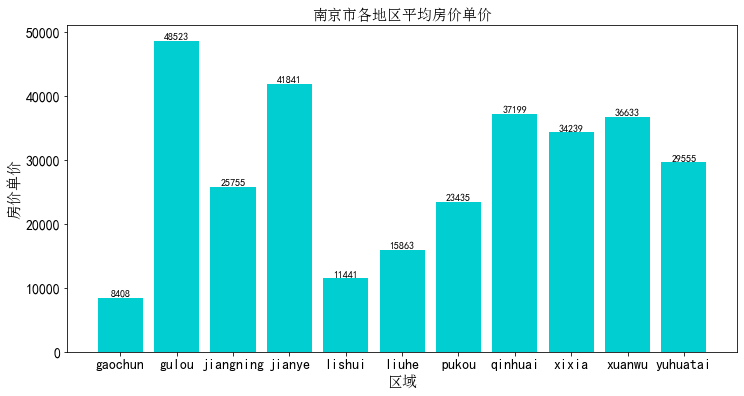

In [10]:
#南京市各地区平均房价单价可视化
region_price_list = df['单价'].groupby(df['区域']).mean().tolist()
region_list = df['单价'].groupby(df['区域']).mean().index.tolist()
plt.figure(figsize=(12,6))
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=15)
plt.bar(region_list,region_price_list,color="#00CED1")
plt.title(u'南京市各地区平均房价单价',fontsize=20,fontproperties=font_set)
plt.xlabel(u'区域',fontsize=18,fontproperties=font_set)
plt.ylabel(u'房价单价',fontsize=18,fontproperties=font_set)
plt.tick_params(labelsize=14)
for a,b in zip(region_list,region_price_list):
    plt.text(a,b+70,"%.0f"%b,ha="center",va="bottom",fontsize=10)
plt.show()

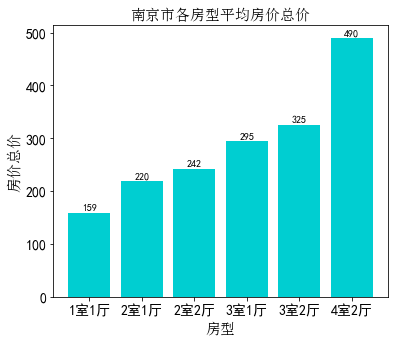

In [11]:
#南京市各房型平均房价总价可视化
region_fangxing_list = df['总价'].groupby(df['房型']).mean().tolist()
region_list = df['总价'].groupby(df['房型']).mean().index.tolist()
plt.figure(figsize=(6,5))
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=15)
plt.bar(region_list,region_fangxing_list,color="#00CED1")
plt.title(u'南京市各房型平均房价总价',fontsize=20,fontproperties=font_set)
plt.xlabel(u'房型',fontsize=18,fontproperties=font_set)
plt.ylabel(u'房价总价',fontsize=18,fontproperties=font_set)
plt.tick_params(labelsize=14)
for a,b in zip(region_list,region_fangxing_list):
    plt.text(a,b+2,"%.0f"%b,ha="center",va="bottom",fontsize=10)
    
plt.show()

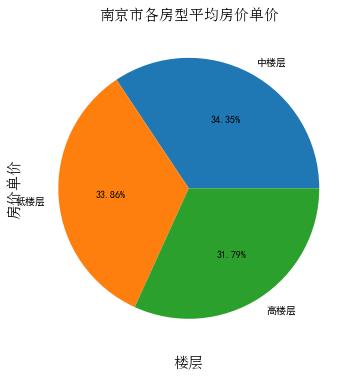

In [12]:
#南京市各房型平均房价单价可视化
region_louceng_list = df['单价'].groupby(df['楼层']).mean().tolist()
region_list = df['单价'].groupby(df['楼层']).mean().index.tolist()
plt.figure(figsize=(6,6))
plt.pie(region_louceng_list,labels=region_list,autopct='%3.2f%%')
plt.title(u'南京市各房型平均房价单价',fontsize=20,fontproperties=font_set)
plt.xlabel(u'楼层',fontsize=18,fontproperties=font_set)
plt.ylabel(u'房价单价',fontsize=18,fontproperties=font_set)
plt.tick_params(labelsize=14)
plt.show()

In [13]:
#机器学习建模
def mean_price_category(value):
    if(value<10000):
        return 1
    if(value<20000):
        return 2
    if(value<30000):
        return 3
    if(value<40000):
        return 4
    if(value<50000):
        return 5
    if(value<60000):
        return 6
    if(value<70000):
        return 7
    if(value<80000):
        return 8
    else:
        return 9

In [14]:
df["单价"] = df["单价"].map(lambda x:mean_price_category(x))

In [16]:
#将多分类变量转换为数值型变量
labels = df["区域"].unique().tolist()
df["区域"] = df["区域"].apply(lambda x: labels.index(x))
labels = df["房型"].unique().tolist()
df["房型"] = df["房型"].apply(lambda x: labels.index(x))
labels = df["朝向"].unique().tolist()
df["朝向"] = df["朝向"].apply(lambda x: labels.index(x))
labels = df["装修"].unique().tolist()
df["装修"] = df["装修"].apply(lambda x: labels.index(x))
labels = df["楼层"].unique().tolist()
df["楼层"] = df["楼层"].apply(lambda x: labels.index(x))
labels = df["房屋类型"].unique().tolist()
df["房屋类型"] = df["房屋类型"].apply(lambda x: labels.index(x))

In [18]:
df = df.drop("面积",axis=1).drop("始建年份",axis=1).drop("总价",axis=1)#删除不必要的列特征

In [20]:
df_target = df["单价"]#选择目标

In [22]:
df_features = df.drop("单价",axis=1)
df_features = df_features.values

In [23]:
print(df_features)

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  1,  1,  0],
       [ 0,  1,  0,  1,  0,  0],
       ...,
       [10,  0,  1,  0,  1,  0],
       [10,  4,  1,  1,  1,  0],
       [10,  4,  1,  2,  1,  0]], dtype=int64)

In [24]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df_features,df_target,test_size=0.3)#划分测试集训练集

In [25]:
clf = tree.DecisionTreeClassifier(criterion="entropy")#构建模型
clf = clf.fit(Xtrain, Ytrain)
score = clf.score(Xtest, Ytest) #返回预测的准确度accuracy
print(score)

0.5020661157024794

In [26]:
feature_name = ['区域','房型','朝向','装修','楼层','房屋类型']#添加特征名

In [27]:
print(clf.feature_importances_)#特征重要性

array([0.52950945, 0.12493411, 0.09702636, 0.06813847, 0.09081566,
       0.08957595])

In [28]:
print([*zip(feature_name,clf.feature_importances_)])#展现重要性

[('区域', 0.5295094486134014),
 ('房型', 0.12493411094168208),
 ('朝向', 0.09702636270752445),
 ('装修', 0.06813846745591162),
 ('楼层', 0.09081565530047828),
 ('房屋类型', 0.08957595498100189)]

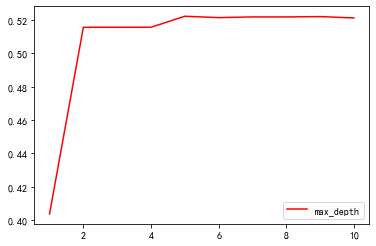

In [32]:
test = []
for i in range(10):#遍历不同的深度
    clf = tree.DecisionTreeClassifier(max_depth=i+1
                                    ,criterion="entropy"
                                    ,random_state=30
                                    ,splitter="random"
                                    )
    clf = clf.fit(Xtrain, Ytrain)
    score = clf.score(Xtest, Ytest)
    test.append(score)
plt.plot(range(1,11),test,color="red",label="max_depth")
plt.legend()
plt.show()